In [1]:
import torch 

## Imaging  library
from PIL import Image
from torchvision import transforms as tfms

from torch import autocast
## Basic libraries
# from fastdownload import FastDownload
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from IPython.display import display
import shutil
import os

## For video display
from IPython.display import HTML
from base64 import b64encode


## Import the CLIP artifacts 
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler

## Initiating tokenizer and encoder.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")

## Initiating the VAE
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", torch_dtype=torch.float16).to("cuda")

## Initializing a scheduler and Setting number of sampling steps
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
scheduler.set_timesteps(50)

## Initializing the U-Net model
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")


## Helper functions
def load_image(p):
    '''
    Function to load images from a defined path
    '''
    return Image.open(p).convert('RGB').resize((512,512))

def pil_to_latents(image):
    '''
    Function to convert image to latents
    '''
    init_image = tfms.ToTensor()(image).unsqueeze(0) * 2.0 - 1.0
    init_image = init_image.to(device="cuda", dtype=torch.float16) 
    init_latent_dist = vae.encode(init_image).latent_dist.sample() * 0.18215
    return init_latent_dist

def latents_to_pil(latents):
    '''
    Function to convert latents to images
    '''
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

def text_enc(prompts, maxlen=None):
    '''
    A function to take a texual promt and convert it into embeddings
    '''
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt") 
    return text_encoder(inp.input_ids.to("cuda"))[0].half()

/home/kobayashi/anaconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.22.self_attn.out_proj.weight', 'vision_model.encoder.layers.5.layer_norm2.weight', 'vision_model.encoder.layers.3.mlp.fc2.weight', 'vision_model.encoder.layers.14.layer_norm1.weight', 'vision_model.encoder.layers.16.layer_norm2.bias', 'vision_model.encoder.layers.23.layer_norm1.bias', 'vision_model.encoder.layers.16.self_attn.v_proj.bias', 'vision_model.encoder.layers.17.self_attn.v_proj.weight', 'vision_model.encoder.layers.6.self_attn.k_proj.weight', 'vision_model.encoder.layers.18.layer_norm2.weight', 'vision_model.encoder.layers.9.mlp.fc2.weight', 'vision_model.encoder.l

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


In [4]:
def prompt_2_img_i2i(prompts, init_img, neg_prompts=None, g=7.5, seed=100, strength =0.8, steps=50, dim=512, save_int=False):
    """
    Diffusion process to convert prompt to image
    """
    # Converting textual prompts to embedding
    text = text_enc(prompt) 

    # Adding negative prompt condition
    bs = len(prompts) 
    if not neg_prompts: uncond =  text_enc([""] * bs, text.shape[1])
    # Adding an unconditional prompt , helps in the generation process
    else: uncond =  text_enc(neg_prompts, text.shape[1])
    emb = torch.cat([uncond, text])
    
    # Setting the seed
    if seed: torch.manual_seed(seed)
    
    # Setting number of steps in scheduler
    scheduler.set_timesteps(steps)
    
    # Convert the seed image to latent
    init_latents = pil_to_latents(init_img)
    
    # Figuring initial time step based on strength
    init_timestep = int(steps * strength) 
    timesteps = scheduler.timesteps[-init_timestep]
    timesteps = torch.tensor([timesteps], device="cuda")
    
    # Adding noise to the latents 
    noise = torch.randn(init_latents.shape, generator=None, device="cuda", dtype=init_latents.dtype)
    init_latents = scheduler.add_noise(init_latents, noise, timesteps)
    latents = init_latents
    
    # Computing the timestep to start the diffusion loop
    t_start = max(steps - init_timestep, 0)
    timesteps = scheduler.timesteps[t_start:].to("cuda")
    
    # Iterating through defined steps
    for i,ts in enumerate(tqdm(timesteps)):
        # We need to scale the i/p latents to match the variance
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        
        # Predicting noise residual using U-Net
        with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
            
        # Performing Guidance
        pred = u + g*(t-u)
        
        # Conditioning  the latents
        latents = scheduler.step(pred, ts, latents).prev_sample
        
        # Saving intermediate images
        if save_int: 
            if not os.path.exists(f'./steps'):
                os.mkdir(f'./steps')
            latents_to_pil(latents)[0].save(f'steps/{i:04}.jpeg')
            
    # Returning the latent representation to output an image of 3x512x512
    return latents_to_pil(latents)

100%|██████████| 40/40 [00:04<00:00,  8.75it/s]


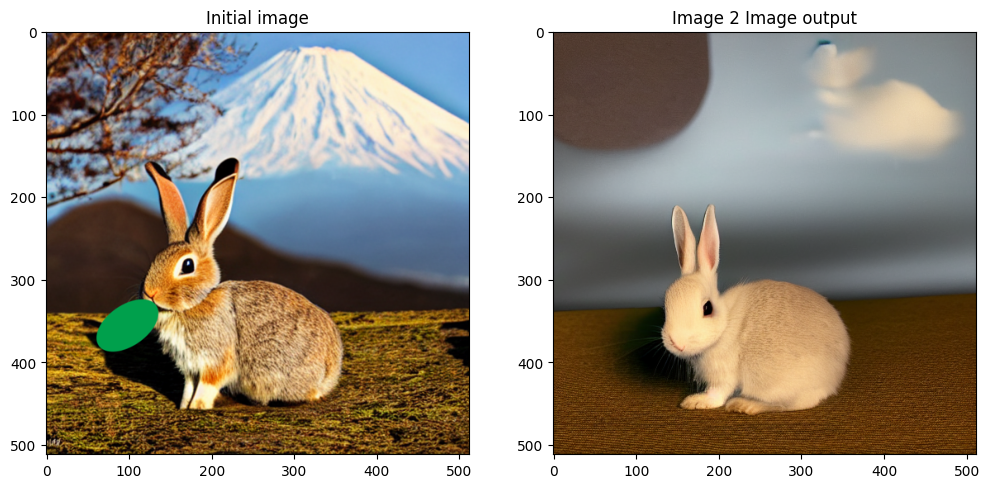

In [9]:
# p = FastDownload().download('https://s3.amazonaws.com/moonup/production/uploads/1664665907257-noauth.png')
# init_img = Image.open("rabbit.png")
# init_img = init_img.resize((512,512))
image = Image.open("rabbit.png").convert('RGB').resize((512,512))
prompt = ["a white rabbit"]
with autocast("cuda"):
    images = prompt_2_img_i2i(prompts = prompt, init_img = image)

## Plotting side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for c, img in enumerate([image, images[0]]): 
    axs[c].imshow(img)
    if c == 0 : axs[c].set_title(f"Initial image")
    else: axs[c].set_title(f"Image 2 Image output")